In [69]:
from CountMin import CountMinSketch
from CountMedian import CountMedianSketch
from DCS import DCS
from DCM import DCM
import scipy.stats as stats
import collections
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bisect
import random
import heapq

In [70]:
def precision(trueHH, estimatedHH):
    TP, FP = 0.0, 0.0
    for item in estimatedHH:
        if item in trueHH:
            TP += 1
        else:
            FP += 1
    return 1.0*TP/(TP+FP)

def recall(trueHH, estimatedHH):
    TP, FN = 0.0, 0.0
    for item in trueHH:
        if item in estimatedHH:
            TP += 1
        else:
            FN += 1
    return 1.0*TP/(TP+FN)

def FScore(trueHH, estimatedHH):
    r = recall(trueHH, estimatedHH)
    p = precision(trueHH, estimatedHH)
    return 2.0*r*p/(r+p)

In [71]:
import socket
import struct
def ip2int(addr):
    return struct.unpack("!I", socket.inet_aton(addr))[0]

df = pd.read_csv('../data/tcp/20151217_125911_dirA.csv',sep='\t')  
sIpStr = df[df.columns[1]].astype(str)
sIp = []
for s in sIpStr:
    item = None
    try:
        item = ip2int(s)
    except:
        pass
    if item:
        sIp.append(item)
print(sIp[:10])

[984025873, 1498711576, 1553990298, 1411326478, 2478817144, 1553990298, 1121727591, 812468610, 2371866058, 1553990298]


In [36]:
def FrequencyEstimation(streamType = "zipf", streamLength = 10**5, dataset = []):
    
    rhos = [0.1,1,10]
    markers = ['o','v','p','']
    assert len(markers) >= len(rhos)
    
    CM_errors = []
    CS_errors = []
    DP_CM_errors = [[] for i in range(len(rhos))]
    DP_CS_errors = [[] for i in range(len(rhos))]
    spaces = []
    
    universe = 2**16
    a = 1.0
    insert_size = streamLength
    runs = 5
    
    caida_start_pos = random.randrange(0, 10530780, 1)
    
    beta = 0.01
    gammas = [2**-9, 2**-10, 2**-11, 2**-12, 2**-13]

    for index, gamma in enumerate(gammas):
        spaces.append(math.log(1.0/beta)/gamma)
        for r in range(runs):
            insertoins = []
            if streamType == "zipf":
                range_x = np.arange(1,universe)
                weights = range_x ** (-a)
                weights /= weights.sum()
                bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))
                insertions = bounded_zipf.rvs(size=insert_size) 
            elif streamType == "CAIDA":
                insertions = dataset[caida_start_pos + (r * insert_size): caida_start_pos + ((r+1) * insert_size) ]
            else:
                insertions = dataset[:]
                
            CM = CountMinSketch(beta, gamma)
            CS = CountMedianSketch(beta, gamma)
            DPCMs = []
            DPCSs = []
            for rho in rhos:
                DPCMs.append(CountMinSketch(beta, gamma, rho))
                DPCSs.append(CountMedianSketch(beta, gamma,rho))
                
            for i in insertions:
                CM.update(i)
                CS.update(i)
                for DPCM in DPCMs:
                    DPCM.update(i)
                for DPCS in DPCSs:
                    DPCS.update(i)
            
            true_result = 0
            
            CM_error, CS_error, CM_estimate, CS_estimate  = 0, 0, 0, 0
            
            DPCM_estimate = [0 for i in range(len(rhos))] 
            DPCS_estimate = [0 for i in range(len(rhos))]
            DPCM_error = [0 for i in range(len(rhos))] 
            DPCS_error = [0 for i in range(len(rhos))]
            
            
            table = collections.Counter(insertions)
            distinct = 0
            for key, val in table.items():
                distinct += 1
                
                CM_estimate = CM.query(key)
                CM_error += abs(CM_estimate - val)/val
                
                CS_estimate = CS.query(key)
                CS_error += abs(CS_estimate - val)/val
                
                for j in range(len(rhos)):
                    DPCM_estimate[j] = DPCMs[j].query(key)
                    DPCM_error[j] += abs(DPCM_estimate[j] - val)/val
                
                    DPCS_estimate[j] = DPCSs[j].query(key)
                    DPCS_error[j] += abs(DPCS_estimate[j] - val)/val
                    

            
            CM_error /= (1.0 * distinct)
            CS_error /= (1.0 * distinct)
            
            for j in range(len(rhos)):
                DPCM_error[j] /= (1.0 * distinct)
                DPCS_error[j] /= (1.0 * distinct)
                
            if r == 0: # first run
                CM_errors.append(CM_error)
                CS_errors.append(CS_error)
                for j in range(len(rhos)):
                    DP_CM_errors[j].append(DPCM_error[j])
                    DP_CS_errors[j].append(DPCS_error[j])
            else:
                CM_errors[-1] += CM_error
                CS_errors[-1] += CS_error
                for j in range(len(rhos)):
                    DP_CM_errors[j][-1] += DPCM_error[j]
                    DP_CS_errors[j][-1] += DPCS_error[j]
    
    for i in range(len(spaces)): # average over runs
        CM_errors[i] /= runs
        CS_errors[i] /= runs
        for j in range(len(rhos)):
            DP_CM_errors[j][i] = DP_CM_errors[j][i] / runs
            DP_CS_errors[j][i] = DP_CS_errors[j][i] / runs
    
        spaces[i] = spaces[i] * 4 / 1024  
    
    title = ""
    if streamType == 'zipf':
            plt.title(title + "Zipf("+str(a)+")", fontsize=18)
    elif streamType == 'CAIDA':
        plt.title(title + "CAIDA", fontsize=18)
    else:
        plt.title(title + "E-Shop", fontsize=18)
        
    plt.xlabel('Space(KB)', fontsize=15)
    plt.xscale('log',basex=2)
    
    plt.ylabel('ARE', fontsize=15)


    symbol = '\u03C1'
    
    plt.plot(spaces, CM_errors, 'bv--', label='CM')
    plt.plot(spaces, CS_errors, 'kx--', label='CS')
    print(spaces)
    print("CM: ", CM_errors)
    print("CS: ", CS_errors)
    
    

    for index, rho in enumerate(rhos):
        plt.plot(spaces, DP_CM_errors[index], markers[index]+'-.', label='CM, '+symbol+'='+str(rho))
        print("CM "+str(rho)+": ", DP_CM_errors[index])
    
    for index, rho in enumerate(rhos):
        plt.plot(spaces, DP_CS_errors[index], markers[index]+'--', label='CS, '+symbol+'='+str(rho))
        print("CS "+str(rho)+": ", DP_CS_errors[index])
        

    plt.legend(prop={'size': 12})
    

[9.210340371976184, 18.420680743952367, 36.841361487904734, 73.68272297580947, 147.36544595161894]
CM:  [420.7239054234391, 420.7239054234391, 411.50808744228834, 405.337668923041, 399.95253998363205]
CS:  [49.75298707421073, 49.75298707421073, 44.27658259693082, 43.22430575914409, 39.42424022462656]
CM 0.1:  [920.6797075152139, 1167.2101286812463, 1520.2964271042702, 2045.0509545154575, 2817.030237011231]
CM 1:  [578.9714883777405, 656.7472793083282, 762.1871780053023, 924.0743329647919, 1164.4660648390254]
CM 10:  [470.77028013441884, 495.3610302388571, 522.3717791468409, 569.319066414281, 641.7267536134292]
CS 0.1:  [49.777306256551164, 49.859952866427925, 44.540320655541485, 43.400768965939534, 39.529938462179445]
CS 1:  [49.75941813515746, 49.78162448558634, 44.28503626286535, 43.24652196973684, 39.3983740351937]
CS 10:  [49.74889993254328, 49.742149321376914, 44.2888699467937, 43.23540345829467, 39.430983943202115]


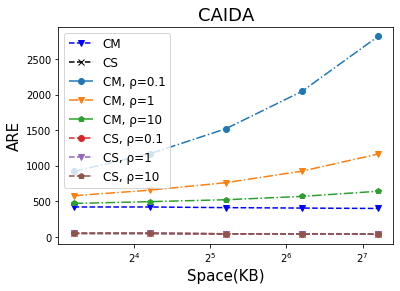

In [37]:
    FrequencyEstimation('CAIDA', 10**5, sIp)

[9.210340371976184, 18.420680743952367, 36.841361487904734, 73.68272297580947, 147.36544595161894]
CM:  [374.3516377496232, 374.38234751534037, 369.23172640648056, 364.5353353431536, 359.28120322101506]
CS:  [50.310381634223134, 50.26884569778966, 46.643939442048065, 44.798148609976394, 40.82178256145714]
CM 0.1:  [942.214797063684, 1221.0949503250988, 1626.8332255729274, 2224.6494044220794, 3100.270282544599]
CM 1:  [553.8477495918378, 642.2298102887371, 766.963806484668, 952.9249893573399, 1226.3662606901992]
CM 10:  [431.1476724333887, 459.05610944590836, 495.03654961360496, 550.5983655859462, 633.4433212141954]
CS 0.1:  [50.43076434159823, 50.55517863904514, 46.88449947792658, 44.96021112707546, 41.02652078681601]
CS 1:  [50.26884326593726, 50.29045784125553, 46.61485465896038, 44.842358975001716, 40.88868730406679]
CS 10:  [50.332598189831785, 50.259818280926126, 46.63774480108209, 44.80897869067064, 40.825945399697545]


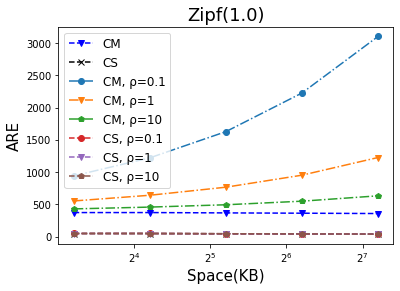

In [38]:
    FrequencyEstimation('zipf', 10**5)

In [64]:
def TopK(streamType = "zipf", k=10, streamLength = 10**5, dataset = []):
    
    rhos = [0.1,1,10]
    markers = ['o','v','p','']
    assert len(markers) >= len(rhos)
    
    CM_errors = []
    CS_errors = []
    DP_CM_errors = [[] for i in range(len(rhos))]
    DP_CS_errors = [[] for i in range(len(rhos))]
    spaces = []
    
    universe = 2**16
    a = 1.0
    insert_size = streamLength
    runs = 5
    
    caida_start_pos = random.randrange(0, 10530780, 1)
    
    beta = 0.01
    gammas = [2**-9, 2**-10, 2**-11, 2**-12, 2**-13]

    for index, gamma in enumerate(gammas):
        spaces.append(math.log(1.0/beta)/gamma)
        for r in range(runs):
            insertoins = []
            if streamType == "zipf":
                range_x = np.arange(1,universe)
                weights = range_x ** (-a)
                weights /= weights.sum()
                bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))
                insertions = bounded_zipf.rvs(size=insert_size) 
            elif streamType == "CAIDA":
                insertions = dataset[caida_start_pos + (r * insert_size): caida_start_pos + ((r+1) * insert_size) ]
            else:
                insertions = dataset[:]
                
            CM = CountMinSketch(beta, gamma)
            CS = CountMedianSketch(beta, gamma)
            DPCMs = []
            DPCSs = []
            for rho in rhos:
                DPCMs.append(CountMinSketch(beta, gamma, rho))
                DPCSs.append(CountMedianSketch(beta, gamma,rho))
                
            for i in insertions:
                CM.update(i)
                CS.update(i)
                for DPCM in DPCMs:
                    DPCM.update(i)
                for DPCS in DPCSs:
                    DPCS.update(i)
            
            true_result = 0
            
            CM_error, CS_error, CM_estimate, CS_estimate  = 0, 0, 0, 0
            
            DPCM_estimate = [0 for i in range(len(rhos))] 
            DPCS_estimate = [0 for i in range(len(rhos))]
            DPCM_error = [0 for i in range(len(rhos))] 
            DPCS_error = [0 for i in range(len(rhos))]
            
            CM_dic = {}
            CS_dic = {}
            DPCM_dic = [{} for i in range(len(rhos))] 
            DPCS_dic = [{} for i in range(len(rhos))]
            
            
            table = collections.Counter(insertions)
            trueTopK = heapq.nlargest(k, table, key=table.get)
            
            for key, val in table.items():
                
                CM_estimate = CM.query(key)
                CM_dic[key] = CM_estimate

                CS_estimate = CS.query(key)
                CS_dic[key] = CS_estimate
                
                for j in range(len(rhos)):
                    DPCM_dic[j][key] = DPCMs[j].query(key)
                    DPCS_dic[j][key] = DPCSs[j].query(key)
            
            
            CM_error = FScore(trueTopK, heapq.nlargest(k, CM_dic, key=CM_dic.get))
            CS_error = FScore(trueTopK, heapq.nlargest(k, CS_dic, key=CS_dic.get))
            
            for j in range(len(rhos)):
                DPCM_error[j] = FScore(trueTopK, heapq.nlargest(k, DPCM_dic[j], key=DPCM_dic[j].get))
                DPCS_error[j] = FScore(trueTopK, heapq.nlargest(k, DPCS_dic[j], key=DPCS_dic[j].get))
                
            if r == 0: # first run
                CM_errors.append(CM_error)
                CS_errors.append(CS_error)
                for j in range(len(rhos)):
                    DP_CM_errors[j].append(DPCM_error[j])
                    DP_CS_errors[j].append(DPCS_error[j])
            else:
                CM_errors[-1] += CM_error
                CS_errors[-1] += CS_error
                for j in range(len(rhos)):
                    DP_CM_errors[j][-1] += DPCM_error[j]
                    DP_CS_errors[j][-1] += DPCS_error[j]
    
    for i in range(len(spaces)): # average over runs
        CM_errors[i] /= runs
        CS_errors[i] /= runs
        for j in range(len(rhos)):
            DP_CM_errors[j][i] = DP_CM_errors[j][i] / runs
            DP_CS_errors[j][i] = DP_CS_errors[j][i] / runs
    
        spaces[i] = spaces[i] * 4 / 1024  
    title = ""
    
    if streamType == 'zipf':
            plt.title(title + "Zipf("+str(a)+")", fontsize=18)
    elif streamType == 'CAIDA':
        plt.title(title + "CAIDA", fontsize=18)
    else:
        plt.title(title + "E-Shop", fontsize=18)
        
    plt.xlabel('Space(KB)', fontsize=15)
    plt.xscale('log',basex=2)
    
    plt.ylabel('F1 Score', fontsize=15)


    symbol = '\u03C1'
    
    plt.plot(spaces, CM_errors, 'bv--', label='CM')
    plt.plot(spaces, CS_errors, 'kx--', label='CS')
    print(spaces)
    print("CM: ", CM_errors)
    print("CS: ", CS_errors)
    
    

    for index, rho in enumerate(rhos):
        plt.plot(spaces, DP_CM_errors[index], markers[index]+'-.', label='CM, '+symbol+'='+str(rho))
        print("CM "+str(rho)+": ", DP_CM_errors[index])
    
    for index, rho in enumerate(rhos):
        plt.plot(spaces, DP_CS_errors[index], markers[index]+'--', label='CS, '+symbol+'='+str(rho))
        print("CS "+str(rho)+": ", DP_CS_errors[index])
        

    plt.legend(prop={'size': 12})

[9.210340371976184, 18.420680743952367, 36.841361487904734, 73.68272297580947, 147.36544595161894]
CM:  [0.7600000000000001, 0.7600000000000001, 0.8, 0.8200000000000001, 0.8]
CS:  [0.6199999999999999, 0.6199999999999999, 0.76, 0.7200000000000001, 0.8200000000000001]
CM 0.1:  [0.76, 0.7600000000000001, 0.8200000000000001, 0.8000000000000002, 0.8]
CM 1:  [0.7600000000000001, 0.7600000000000001, 0.8, 0.8, 0.8]
CM 10:  [0.7600000000000001, 0.7600000000000001, 0.8, 0.8200000000000001, 0.8]
CS 0.1:  [0.64, 0.64, 0.76, 0.7200000000000001, 0.8200000000000001]
CS 1:  [0.6199999999999999, 0.6199999999999999, 0.76, 0.7200000000000001, 0.8200000000000001]
CS 10:  [0.6199999999999999, 0.6199999999999999, 0.76, 0.7200000000000001, 0.8200000000000001]


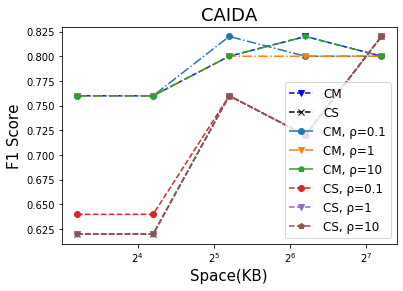

In [67]:
TopK("CAIDA", 10, 10**5, sIp)

[9.210340371976184, 18.420680743952367, 36.841361487904734, 73.68272297580947, 147.36544595161894]
CM:  [1.0, 1.0, 1.0, 1.0, 1.0]
CS:  [0.8400000000000001, 0.9, 0.9800000000000001, 1.0, 0.96]
CM 0.1:  [1.0, 1.0, 1.0, 1.0, 1.0]
CM 1:  [1.0, 1.0, 1.0, 1.0, 1.0]
CM 10:  [1.0, 1.0, 1.0, 1.0, 1.0]
CS 0.1:  [0.8400000000000001, 0.9, 0.9800000000000001, 1.0, 0.96]
CS 1:  [0.8400000000000001, 0.9, 0.9800000000000001, 0.9800000000000001, 0.96]
CS 10:  [0.8400000000000001, 0.9, 0.9800000000000001, 1.0, 0.96]


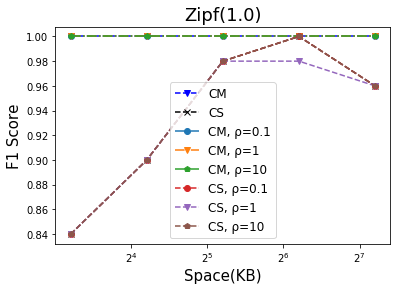

In [63]:
TopK("zipf", 10, 10**5)

In [90]:
def quantileApproximation(streamType = "zipf", U = 2**16, streamLength = 10**5, dataset = []):
    
    rhos = [0.1,1,10]
    markers = ['o','v','p','']
    assert len(markers) >= len(rhos)
    
    CM_errors = []
    CS_errors = []
    DP_CM_errors = [[] for i in range(len(rhos))]
    DP_CS_errors = [[] for i in range(len(rhos))]
    
    universe = U
    a = 1.0
    insert_size = streamLength
    runs = 5
    
    caida_start_pos = random.randrange(0, 10530780, 1)
    
    gamma = 0.01
    print("gamma: ", gamma)
    quantiles = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10]

    for index, m in enumerate(quantiles):
        for r in range(runs):
            insertoins = []
            if streamType == "zipf":
                range_x = np.arange(1,universe)
                weights = range_x ** (-a)
                weights /= weights.sum()
                bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))
                insertions = bounded_zipf.rvs(size=insert_size) 
            elif streamType == "CAIDA":
                insertions = dataset[caida_start_pos + (r * insert_size): caida_start_pos + ((r+1) * insert_size) ]
            else:
                insertions = dataset[:]

            CS = DCS(universe, gamma)
            DPCSs = []
            for rho in rhos:
                DPCSs.append(DCS(universe, gamma, rho))
                
            for i in insertions:
                CS.update(i)
                for DPCS in DPCSs:
                    DPCS.update(i)
            
            CM_error, CS_error, CM_estimate, CS_estimate  = 0, 0, 0, 0
            
            DPCM_estimate = [0 for i in range(len(rhos))] 
            DPCS_estimate = [0 for i in range(len(rhos))]
            DPCM_error = [0 for i in range(len(rhos))] 
            DPCS_error = [0 for i in range(len(rhos))]
            
            
            
            table = sorted(insertions)
            
            for i in range(1,m+1):
                q = 1.0*i/(m+1)
                trueRank = math.ceil(q * streamLength)
                key = table[trueRank-1]
                
                while table[trueRank] == key:
                    # account for duplicate keys
                    trueRank += 1
                
                val = trueRank
                assert table[val-1] == key
                
                CS_estimate = CS.query(key+1)
                CS_error += abs(CS_estimate - val)
                
                #print(key, val)
                #print("DCS estimate: ", CS_estimate)
                
                for j in range(len(rhos)):
                    DPCS_estimate[j] = DPCSs[j].query(key+1)
                    DPCS_error[j] += abs(DPCS_estimate[j] - val)
            
            CS_error /= (1.0 * m)
            
            for j in range(len(rhos)):
                DPCS_error[j] /= (1.0 * m)
                
            if r == 0: # first run
                CS_errors.append(CS_error)
                for j in range(len(rhos)):
                    DP_CS_errors[j].append(DPCS_error[j])
            else:
                CS_errors[-1] += CS_error
                for j in range(len(rhos)):
                    DP_CS_errors[j][-1] += DPCS_error[j]
    
    for i in range(len(quantiles)): # average over runs
        CS_errors[i] /= (runs)
        for j in range(len(rhos)):
            DP_CS_errors[j][i] = DP_CS_errors[j][i] / (runs)
    title = ""
    
    if streamType == 'zipf':
            plt.title(title + "Zipf("+str(a)+")", fontsize=18)
    elif streamType == 'CAIDA':
        plt.title(title + "CAIDA", fontsize=18)
    else:
        plt.title(title + "E-Shop", fontsize=18)
        
    plt.xlabel('# quantiles', fontsize=15)
    plt.xscale('log',basex=2)
    
    
    plt.ylabel('Average Rank Error', fontsize=15)


    symbol = '\u03C1'
    
    plt.plot(quantiles, CS_errors, 'kx--', label='DCS')
    print(quantiles)
    print("DCS: ", CS_errors)
    
    for index, rho in enumerate(rhos):
        plt.plot(quantiles, DP_CS_errors[index], markers[index]+'--', label='DCS, '+symbol+'='+str(rho))
        print("DCS "+str(rho)+": ", DP_CS_errors[index])
        

    plt.legend(prop={'size': 12})

gamma:  0.01
[32, 64, 128, 256, 512, 1024]
DCS:  [30.875, 30.675, 33.8578125, 31.75, 33.5703125, 31.2275390625]
DCS 0.1:  [44.78394385874272, 41.68740100562572, 42.00350722670555, 44.700466299429536, 44.67042390871793, 43.070659539126794]
DCS 1:  [32.503038215637204, 31.887436175346373, 35.58466903716326, 33.943369537219404, 35.18246898148209, 32.006526108609975]
DCS 10:  [31.18794227093458, 30.755561788380145, 33.63257193434983, 31.777189033757896, 33.79287810409441, 31.401572000980376]


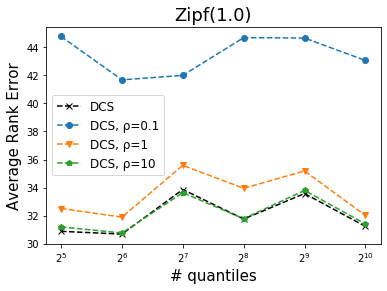

In [91]:
    quantileApproximation("zipf", 2**16, 10**5)

gamma:  0.01
[32, 64, 128, 256, 512, 1024]
DCS:  [70.76875, 75.759375, 67.24375, 67.5828125, 66.759765625, 65.887109375]
DCS 0.1:  [99.7029125098139, 112.44538923753426, 98.37432762552052, 100.46083746600198, 101.42500220921356, 101.54339909809678]
DCS 1:  [71.79444646108895, 80.33514114492573, 70.93021793969675, 72.62050544530211, 70.86941799161723, 68.9154595663751]
DCS 10:  [72.51943447808154, 76.40623527860734, 67.08898429060828, 68.44933029610256, 67.33541661979052, 66.268664712618]


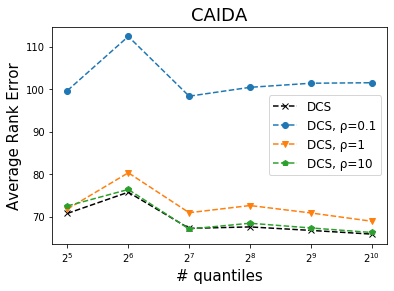

In [93]:
    quantileApproximation("CAIDA", 2**32, 10**5, sIp)